# Climate dynamics:
## Predicting the weather: spatial patterns approach
In this part of the climate dynamics tutorial, we will try to predict the temperature in Oxford in November 2100. Here we will use idealised climate model output to estimate the spatial patterns of climate change.
First, import everything we need.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import glob
from scipy.constants import convert_temperature

Predicting long-term climate change requires using climate model scenarios. We will use two equilibrium climate simulations and interpolate between the two: a 4xCO2 scenario and a pre-industrial scenario. Open the data.

In [2]:
data_path_PI = "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20190410/"
filename_PI = f"{data_path_PI}tas_Amon_UKESM1-0-LL_piControl_r1i1p1f2_gn_196001-204912.nc"
ds_PI = xr.open_dataset(filename_PI)

In [3]:
data_path_4xCO2 = "/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/abrupt-4xCO2/r1i1p1f2/Amon/tas/gn/v20190406/"
filename_4xCO2 = f"{data_path_4xCO2}tas_Amon_UKESM1-0-LL_abrupt-4xCO2_r1i1p1f2_gn_195001-199912.nc"
ds_4xCO2 = xr.open_dataset(filename_4xCO2)
ds_4xCO2

<xarray.Dataset> Size: 66MB
Dimensions:    (time: 600, bnds: 2, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 5kB 1950-01-16 00:00:00 ... 1999-12-16 00:00:00
  * lat        (lat) float64 1kB -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * lon        (lon) float64 2kB 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 10kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 2kB dask.array<chunksize=(144, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
    tas        (time, lat, lon) float32 66MB dask.array<chunksize=(1, 144, 192), meta=np.ndarray>
Attributes: (12/46)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  39600.0
    creation_date:          2019-04-05T15:14:37Z
    ...                     ...
    title:                  UKESM1-0-LL output prepared for CMIP6
    variable_id:            tas
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/07719010-69f1-4046-b04f-05ddaf0d1ee8

These are long stable simulations and we are interested in long term climate statistics, so we can average over time and look at the differences between the two simulations. 

In [4]:
# Average over time and get just pattern
surface_temp_PI = ds_PI["tas"].mean(dim="time")
surface_temp_4xCO2 = ds_4xCO2["tas"].mean(dim="time")

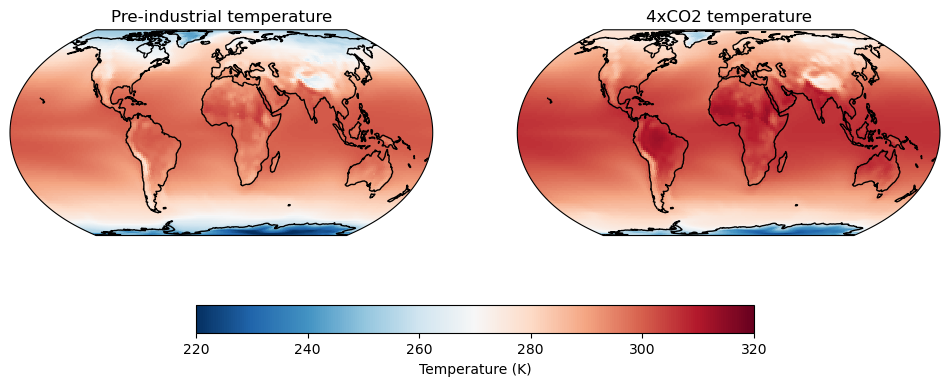

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), 
                       subplot_kw={'projection': ccrs.EqualEarth(central_longitude=0)})
    
axs[0].coastlines()
colormap_PI = axs[0].pcolormesh(surface_temp_PI.lon, 
                                surface_temp_PI.lat, 
                                surface_temp_PI,
                                vmin=220, vmax=320, 
                                cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[0].set_title("Pre-industrial temperature")

axs[1].coastlines()
plt.sca(axs[1])
colormap_4xCO2 = axs[1].pcolormesh(surface_temp_4xCO2.lon, 
                                   surface_temp_4xCO2.lat, 
                                   surface_temp_4xCO2,
                                   vmin=220, vmax=320,
                                   cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[1].set_title("4xCO2 temperature")

plt.colorbar(colormap_PI, ax=axs, 
             location="bottom", 
             orientation="horizontal",
             shrink=0.6,
             label="Temperature (K)")


## Pattern scaling
A simple approach to interpolate between these two climates at the year 2100 is called "Pattern Scaling" (Santer, 1990, Mitchell, 2003). This has been used for many years and still holds up fairly well. It assumes that the global warming pattern remains constant and is scaled by a scaler variable, such as global mean temperature. Then, we can estimate the global warming changes as
$$P(x,y) =  \frac{\Delta T}{\Delta T_{ref}} P_{ref}(x,y) $$
where $P_{ref}(x,y)$ is a reference global warming pattern, $\Delta T_{ref}$ is the global mean temperature change in the reference scenario and $\Delta T$ is the global mean temperature change in the new scenario. Note that we have to estimate the latter from somewhere, such as the IPCC report, an energy balance model, a climate model emulator. We will assume that in 2100 the global mean temperature change relative to pre-industrial is ~3K [IPCC, 2021].
1. Take temperature difference between two scenarios
2. Normalise pattern by global mean temperature change - this gives the pattern of warming per 1K of warming (so should be centered around 1).
3. Scale the pattern by the new global mean temperature change

In [6]:
# Temperature anomaly
surface_temp_anom = surface_temp_4xCO2 - surface_temp_PI

In [9]:
# Normalise by ratio of global mean temperatures
# Don't forget to take an area weighted mean to account for different grid cell sizes)
weights = np.cos(np.deg2rad(surface_temp_anom.lat))
weights.name = "weights"
surface_temp_anom_weighted = surface_temp_anom.weighted(weights)
global_mean_surface_temp_diff = surface_temp_anom_weighted.mean(("lon", "lat"))
print(global_mean_surface_temp_diff.values)
surface_temp_pattern = surface_temp_anom / global_mean_surface_temp_diff

7.556551609796496


In [10]:
surface_temp_pattern.weighted(weights).mean().values

array(1.)

Text(0.5, 1.0, 'Normalised warming pattern')

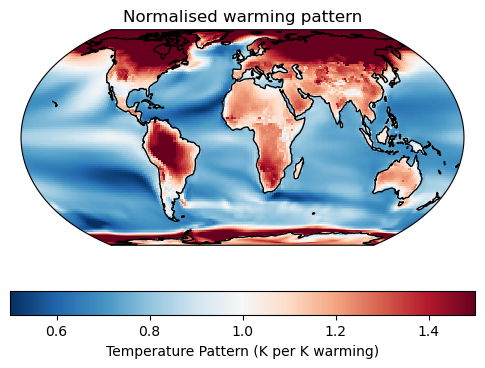

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), 
                       subplot_kw={'projection': ccrs.EqualEarth(central_longitude=0)})
    
ax.coastlines()
plt.sca(ax)
    
plt.pcolormesh(surface_temp_pattern.lon, surface_temp_pattern.lat, surface_temp_pattern, 
               vmin=0.5, vmax=1.5, 
               cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(location="bottom", orientation="horizontal", label="Temperature Pattern (K per K warming)")

ax.set_title("Normalised warming pattern")


In [12]:
# Scale this pattern based on global mean temperature increase in year 2024 
dT = 3.0
projected_surface_temp_change = surface_temp_pattern * dT
projected_surface_temp = surface_temp_PI + projected_surface_temp_change

Text(0.5, 1.0, 'Projected Surface Temperature Change from Pre-Industrial')

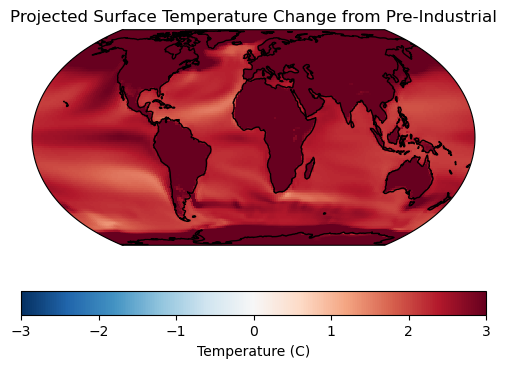

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), 
                       subplot_kw={'projection': ccrs.EqualEarth(central_longitude=0)})
    
ax.coastlines()
plt.sca(ax)
    
plt.pcolormesh(projected_surface_temp.lon, projected_surface_temp.lat, projected_surface_temp_change, 
               vmin=-3, vmax=3, 
               cmap="RdBu_r", transform=ccrs.PlateCarree())
plt.colorbar(location="bottom", orientation="horizontal", label="Temperature (C)")

ax.set_title("Projected Surface Temperature Change from Pre-Industrial")


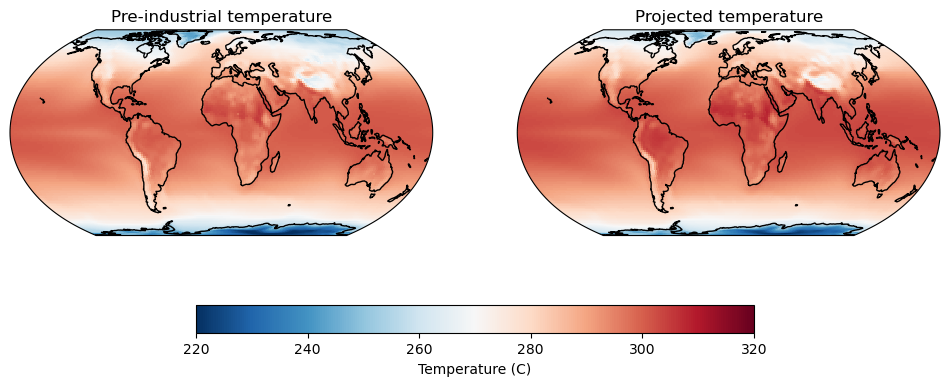

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), 
                       subplot_kw={'projection': ccrs.EqualEarth(central_longitude=0)})
    
axs[0].coastlines()
colormap_PI = axs[0].pcolormesh(surface_temp_PI.lon, 
                                surface_temp_PI.lat, 
                                surface_temp_PI,
                                vmin=220, vmax=320, 
                                cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[0].set_title("Pre-industrial temperature")

axs[1].coastlines()
plt.sca(axs[1])
colormap_proj = axs[1].pcolormesh(projected_surface_temp.lon, 
                                   projected_surface_temp.lat, 
                                   projected_surface_temp,
                                   vmin=220, vmax=320,
                                   cmap="RdBu_r", transform=ccrs.PlateCarree())
axs[1].set_title("Projected temperature")

plt.colorbar(colormap_PI, ax=axs, 
             location="bottom", 
             orientation="horizontal",
             shrink=0.6,
             label="Temperature (C)")


In [15]:
surface_temp_oxford = projected_surface_temp.sel(lat=51.7520, lon=1.2577, method='nearest')

In [16]:
projected_surface_temp_change.sel(lat=51.7520, lon=1.2577, method='nearest').values

array(2.68609393)

In [17]:
surface_temp_oxford.values

array(285.86230243)

## Advanced: Consider scenario uncertainty
We assumed the global mean temperature change in year 2100 was 3K, based on SSPxx (cite IPCC report). Can you add some uncertainties to this prediction? Can you also explore different scenarios?

## Additional questions
1. How would you include seasonal information?
2. We assumed linearity, how could you improve upon this?
3. How would you provide uncertainty estimates?
4. Could you do the same for other variables such as precipitation?

## References
* Santer, B. D., Wigley, T. M., Schlesinger, M. E., & Mitchell, J. F. (1990). Developing climate scenarios from equilibrium GCM results.
* Mitchell, T. D. (2003). Pattern scaling: an examination of the accuracy of the technique for describing future climates. Climatic change, 60(3), 217-242.
* Tebaldi, C., & Arblaster, J. M. (2014). Pattern scaling: Its strengths and limitations, and an update on the latest model simulations. Climatic Change, 122, 459-471.
* IPCC, 2021: Summary for Policymakers. In: Climate Change 2021: The Physical Science Basis. Contribution of Working Group I to the Sixth Assessment Report of the Intergovernmental Panel on Climate Change [Masson-Delmotte, V., P. Zhai, A. Pirani, S.L. Connors, C. Péan, S. Berger, N. Caud, Y. Chen, L. Goldfarb, M.I. Gomis, M. Huang, K. Leitzell, E. Lonnoy, J.B.R. Matthews, T.K. Maycock, T. Waterfield, O. Yelekçi, R. Yu, and B. Zhou (eds.)]. In Press.